# Preface

In this notebook, we apply model-based algorithms to solve a simple RL problem: FrozenWorld.

The main purpose is to introduce the algorithm and also the `OpenAI Gym` environment that allows easy testing of RL algorithms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")
np.random.seed(123)  # For reproducibility

# FrozenWorld and the OpenAI Gym Environment

`OpenAI Gym` is a benchmarking platform for reinforcement learning algorithms. It provides a unified API to specify environments. 

There are a variety of test problems, including
   * Toy problems
   * Basic control problems
   * Atari games
   
You can read more about it [here](https://gym.openai.com/).

In [2]:
import gym

We are going to use a specific environment The **Frozen-World**:

The environment consists of 4x4=16 tiles of 4 types:
   * S = starting point, safe
   * F = frozen surface, safe
   * H = hole, unsafe
   * G = goal
   
The agent navigates the environment by choosing an action: left, right, up or down.

However, the world is *slippery*, so that even if you choose an action, you might not always end up where you are! We will see this later.

The goal of the agent is to get to the G (goal) tile, without dropping into the H (hole) tile. When either G or H are reached, the game terminates. The agent receives reward of +1 only when it ends up on a G tile. 

![Image](https://miro.medium.com/max/842/1*Qp14HWQfOeE2UoSxrxCxAg.png)

We can create this environment directly using `make`.

In [10]:
env = gym.make('FrozenLake-v1')
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


# Transition Probability

Let us look at the *transition probability*
$$
    p(s', r| s, a)
$$

This is stored in `env.P`. Each `env.P[s][a]` is a list, with each element `env.P[s][a][j]` a tuple
$$
    \left(
        p(s_j,r_j|s,a),
        s_j,
        r_j,
        \text{Status}
    \right)
$$
`Status` equals `True` if the episode ends. Otherwise it is `False`.

Note that in this game, the actions are organized as 
```
    0: left
    1: down
    2: right
    3: up
```

For example, we can look at the transition probability at the first state, if we were to go downwards ($a=1$)

In [11]:
env.render()
env.P[0][1]


SFFF
FHFH
FFFH
HFFG


[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 4, 0.0, False),
 (0.3333333333333333, 1, 0.0, False)]

We make a step, calling the `step` method, which applies the action to the system.

The method returns a tuple (next_state, reward, status, info)

In [12]:
state, reward, status, info = env.step(action=1)
print(f'State: {state}\nReward: {reward}\nStates: {status}\nInfo: {info}')

State: 1
Reward: 0.0
States: False
Info: {'prob': 0.3333333333333333}


In [13]:
env.render()

  (Down)
SFFF
FHFH
FFFH
HFFG


Let's now go right...

In [14]:
env.render()
env.P[state][2]

  (Down)
SFFF
FHFH
FFFH
HFFG


[(0.3333333333333333, 5, 0.0, True),
 (0.3333333333333333, 2, 0.0, False),
 (0.3333333333333333, 1, 0.0, False)]

In [15]:
state, reward, status, info = env.step(action=2)
print(f'State: {state}\nReward: {reward}\nStates: {status}\nInfo: {info}')

State: 1
Reward: 0.0
States: False
Info: {'prob': 0.3333333333333333}


In [ ]:
env.render()

# Model Based Policy Iteration

## Policy Evaluation

Given policy $\pi$, we evaluate $v_\pi(s)$ for all $s\in\mathcal{S}$.

This is done by an iterative solution of the Bellman's equation.

In [16]:
def policy_evaluation(env, policy, gamma, max_iter):
    """
    Evaluate a (deterministic) policy
        Here, a policy is an iterable of size nS (number of states)
        giving an action to take for each state
        
        Other stopping criteria are also possible
    """
    value_function = np.zeros(env.nS)
    
    for _ in range(max_iter):
        tmp = np.zeros_like(value_function)
        
        # Compute right hand side of Bellman Equation
        for state, action in enumerate(policy):
            for probablity, next_state, reward, _ in env.P[state][action]:
                tmp[state] += probablity * (
                    reward + gamma * value_function[next_state])
        value_function = tmp

    return value_function

Let us evaluate the value function of a randomly generated policy

In [25]:
policy = np.random.choice(range(env.nA), size=(env.nS))
value_function = policy_evaluation(env=env, policy=policy, gamma=1.0, max_iter=1000)

print(value_function)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



SFFF
FHFH
FFFH
HFFG


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

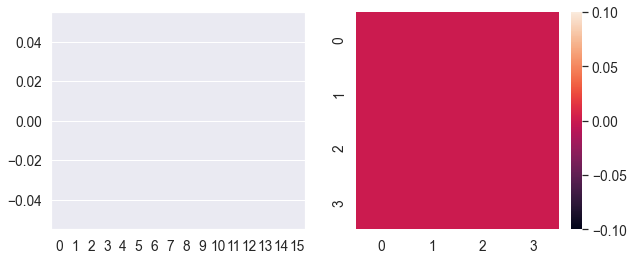

In [26]:
env.reset()
env.render()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(np.arange(env.nS), value_function, ax=ax[0])
sns.heatmap(value_function.reshape(4, 4), ax=ax[1])

## Policy Improvement

Given a policy $\pi$, we can improve it by computing the *action value function*
$$
    q_\pi(s, a) = \sum_{s',r} p(s',r|s,a)(r + \gamma v_\pi(s'))
$$

Given an action value function, we improve policy by
$$
    \pi'(s) = \mathrm{arg\,max}_{a} q_\pi(s, a)
$$

In [27]:
def compute_action_value(env, state, value_function, gamma):
    """
    Computes q(state, \cdot)
    """
    action_values = np.zeros(env.nA)
    for action in range(env.nA):
        for probablity, next_state, reward, info in env.P[state][action]:
            action_values[action] += probablity * (
                reward + (gamma * value_function[next_state]))
    return action_values

In [28]:
def policy_improvement(env, value_function, gamma):
    """
    Improve a current policy by acting greedily with respect
    to the action value function
    """
    policy = np.zeros(env.nS)
    for state in range(env.nS):
        action_values = compute_action_value(env, state, value_function, gamma)
        policy[state] = np.argmax(action_values)  # pick action to maximize action-value
    return policy

We take the randomized policy as before. To visualize it we define an action map

In [29]:
action_map = {
    0: '\u2190',
    1: '\u2193',
    2: '\u2192',
    3: '\u2191',
}
print(action_map)

{0: '←', 1: '↓', 2: '→', 3: '↑'}


In [30]:
def visualize_policy(policy):
    grid = np.array(
        [            
            ['S', 'F', 'F', 'F'],
            ['F', 'H', 'F', 'H'],
            ['F', 'F', 'F', 'H'],
            ['H', 'F', 'F', 'G'],
        ]
    )
    directions = np.array([action_map[p] for p in policy]).reshape(4, 4)
    print(grid)
    print(directions)

In [31]:
visualize_policy(policy)

[['S' 'F' 'F' 'F']
 ['F' 'H' 'F' 'H']
 ['F' 'F' 'F' 'H']
 ['H' 'F' 'F' 'G']]
[['↓' '→' '↑' '↑']
 ['↑' '↓' '↓' '↑']
 ['↓' '→' '↑' '↑']
 ['↑' '↑' '←' '→']]


In [32]:
updated_policy = policy_improvement(env=env, value_function=value_function, gamma=1.0)

In [33]:
visualize_policy(updated_policy)

[['S' 'F' 'F' 'F']
 ['F' 'H' 'F' 'H']
 ['F' 'F' 'F' 'H']
 ['H' 'F' 'F' 'G']]
[['←' '←' '←' '←']
 ['←' '←' '←' '←']
 ['←' '←' '←' '←']
 ['←' '←' '↓' '←']]


## Policy Iteration

Putting things together, we can iterate the steps of policy evaluation and improvement.

In [34]:
def policy_iteration(env, max_iter=100):
    """
    Model-Based Policy Iteration Algorithm
    """
    
    # intialize a random policy
    policy = np.random.choice(range(env.nA), size=(env.nS))
    # maintain a copy to check for convergence
    policy_prev = np.copy(policy)
    
    for i in range(max_iter):
        
        # evaluate policy
        value_function = policy_evaluation(env, policy, 1.0, 100)
        
        # improve policy
        policy = policy_improvement(env, value_function, 1.0)
            
    return value_function, policy

In [35]:
value_function, policy = policy_iteration(env, max_iter=100)


SFFF
FHFH
FFFH
HFFG


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

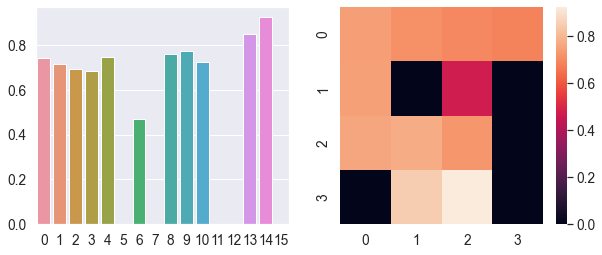

In [36]:
env.reset()
env.render()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(np.arange(env.nS), value_function, ax=ax[0])
sns.heatmap(value_function.reshape(4, 4), ax=ax[1])

In [37]:
visualize_policy(policy)

[['S' 'F' 'F' 'F']
 ['F' 'H' 'F' 'H']
 ['F' 'F' 'F' 'H']
 ['H' 'F' 'F' 'G']]
[['←' '↑' '↑' '↑']
 ['←' '←' '←' '←']
 ['↑' '↓' '←' '←']
 ['←' '→' '↓' '←']]
